In [1]:
using Plots
using Random: MersenneTwister
using StatsBase: mean

include("../src/Simulation.jl")
using .Simulation: Param, Model, run!, resource_allocation!, weighted_interaction!, weighted_death_birth!, C_rate, Strategy, C, D

include("../src/ColorScheme.jl")
using .ColorScheme
const CS = ColorScheme

println("Julia $(VERSION)")
println("Thread count: $(Threads.nthreads())")

Julia 1.10.2
Thread count: 12


In [2]:
default(
    fontfamily="Times New Roman",
    titlefontsize=16,
    guidefontsize=14,
    tickfontsize=11,
    legendfontsize=11,
    margin=5Plots.mm,
);

In [3]:
function moving_average(data::Vector{<:Real}, window_size::Int = 10)::Vector{Float64}
    return [mean(data[max(1, i-window_size):min(end, i+window_size)]) for i in 1:length(data)]
end

function calc_prime_node_shift_vec(peak_node_vec::Vector{Int})::Vector{Float64}
    shift_vec = peak_node_vec[2:end] .- peak_node_vec[1:(end-1)]
    shift_vec = Float64.(abs.(shift_vec))
    shift_vec = [x > 50 ? 100 - x : x for x in shift_vec]

    return shift_vec
end

function line_color(σR::Int)::String
    return if σR == 16
        CS.RED
    elseif σR == 4
        CS.BLUE
    else
        CS.BLACK
    end
end;

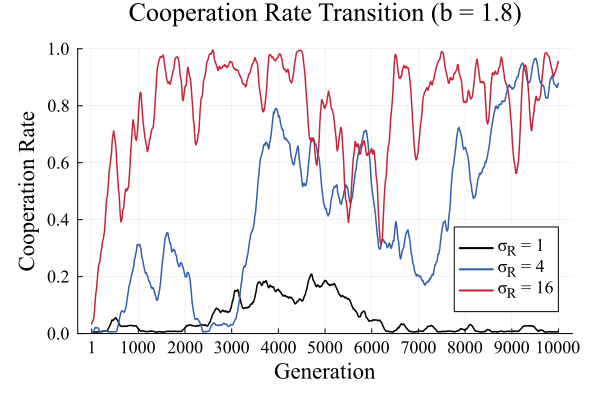

In [4]:
C_rate₀ = 0.0
b = 1.8
relationship_increment_factor = 1.0
resource_decrement_factor = 0.02
resource_limit_μ = 0.5
resource_limit_β = 0.0
resource_limit_σ = 0.0
peak_node_variability_vec = [1, 4, 16]

random_seed = 1
generations = 10_000
window_size = 50

xticks = collect(0:1000:generations)
xticks[1] = 1

plt = plot(
    xlabel="Generation", xticks=xticks,
    ylabel="Cooperation Rate", ylim=(0, 1),
    title="Cooperation Rate Transition (b = $(b))", legend=(0.85, 0.3),
)

for σR in peak_node_variability_vec
    p = Param(
        N = 100, k₀ = 4, generations = generations, b = b, C_rate₀ = C_rate₀,
        peak_node_variability = σR,
        relationship_increment_factor = relationship_increment_factor,
        resource_decrement_factor = resource_decrement_factor,
        resource_limit_μ = resource_limit_μ,
        resource_limit_β = resource_limit_β,
        resource_limit_σ = resource_limit_σ,
    )
    m = Model(p, MersenneTwister(random_seed))
    C_rate_vec, _, _, peak_node_vec = run!(m, MersenneTwister(random_seed))
    pushfirst!(peak_node_vec, 1)

    plot!(moving_average(C_rate_vec, window_size), label="\\sigma_{R} = $(σR)", lc=line_color(σR), lw=1.5)
end

display(plt)
# savefig("img/fig2b.png");

In [5]:
using Graphs
using GraphPlot
using Compose

function plot_graph(m::Model)::Nothing
    println("generation: $(m.t), C rate: $(mean(m.strategy_vec .== C))")
    g = SimpleGraph(m.relation_mat)

    n = nv(g)
    θ = 2 * π / n  # 各ノードの間の角度
    x_coords = [cos(i * θ - π/2) for i in 0:n-1]
    y_coords = [sin(i * θ - π/2) for i in 0:n-1]

    # layout関数を定義してノードの座標を渡す
    layout = (g -> (x_coords, y_coords))

    node_colors = [s == C ? CS.BLUE : CS.RED for s in m.strategy_vec]
    node_sizes = [r * 2 + 0.5 for r in m.resource_vec]
    node_strokel_w_vec = [i == m.peak_node ? 1 : 0 for i in 1:n]
    ctx = gplot(
        g,
        nodelabel=1:n,
        layout=layout,
        nodelabelc="#FFFFFF",
        nodestrokelw=node_strokel_w_vec,
        nodestrokec=CS.BLACK,
        nodefillc=node_colors,
        nodesize=node_sizes,
        edgestrokec=CS.BLACK,
    )
    svg_file = SVG("graph.svg", 400px, 400px)
    draw(svg_file, ctx)  # draw関数で描画を実行
    svg_content = read("graph.svg", String)
    display(MIME("image/svg+xml"), svg_content)
    return
end;

In [81]:
random_seed = 2
p = Param(
    N = 16, k₀ = 2, generations = 1000, b = b, C_rate₀ = C_rate₀,
    peak_node_variability = 4,
    relationship_increment_factor = 1.0,
    resource_decrement_factor = 1/8,
    resource_limit_μ = 0.5,
    resource_limit_β = 0.9,
    resource_limit_σ = 0.0,
)
m = Model(p, MersenneTwister(random_seed))

C_mutation_rate_vec = fill(0.0, m.p.generations)
death_id_vec_vec = fill([0], m.p.generations)
parent_id_vec_vec = fill([0], m.p.generations)
before_death_birth_log = fill(Model(p, MersenneTwister()), p.generations)
after_death_birth_log = fill(Model(p, MersenneTwister()), p.generations)

function run_all!(m::Model, rng::MersenneTwister)::Nothing
    for generation in 1:m.p.generations
        m.t = generation
        resource_allocation!(m, rng)

        # if generation ∈ [133:135; 510:513]
        #     println("==========================================")
        #     println("after resource_allocation!")
        #     println(m.resource_vec)
        #     plot_graph(m)
        # end

        weighted_interaction!(m, rng)

        # if generation ∈ [133:135; 510:513]
        #     println("after weighted_interaction!")
        #     plot_graph(m)
        # end
        # Log
        before_death_birth_log[generation] = deepcopy(m)

        death_id_vec, parent_id_vec, increase_C_count, mutation_C_count = weighted_death_birth!(m, rng)

        # # 親の中で協力者が占める割合が、子の中で協力者が占める割合を上回っていたら、協力率が上昇しやすい
        # if generation ∈ [133:135; 510:513]
        #     println("after weighted_death_birth!")
        #     println("mutation_C_count: $(mutation_C_count)")
        #     println("parent_id_vec: $(parent_id_vec)")
        #     println("death_id_vec: $(death_id_vec)")
        #     plot_graph(m)
        # end

        # Log
        C_mutation_rate_vec[generation] = mutation_C_count / p.N
        death_id_vec_vec[generation] = death_id_vec
        parent_id_vec_vec[generation] = parent_id_vec
        after_death_birth_log[generation] = deepcopy(m)
    end

    return
end

run_all!(m, MersenneTwister(random_seed));

In [83]:
C_rate_vec = [C_rate(m) for m in after_death_birth_log]

bottom = 0.5
top = 0.5
diff = 0.1
span = 1
for t in 1:(p.generations - span)
    c1 = C_rate_vec[t]
    c2 = C_rate_vec[t + span]
    if (c2 > top && c1 < bottom && c2 - c1 > diff) || (c2 < bottom && c1 > top && c1 - c2 > diff)
        println("$(t)〜$(t + span): $(c2) - $(c1) = $(c2 - c1)")
    end
end;

866〜867: 0.4375 - 0.625 = -0.1875


sum(parent_C_rate_vec .- children_C_rate_vec .> 0) = 91
sum(parent_C_rate_vec .- children_C_rate_vec .== 0) = 794
sum(parent_C_rate_vec .- children_C_rate_vec .< 0) = 115


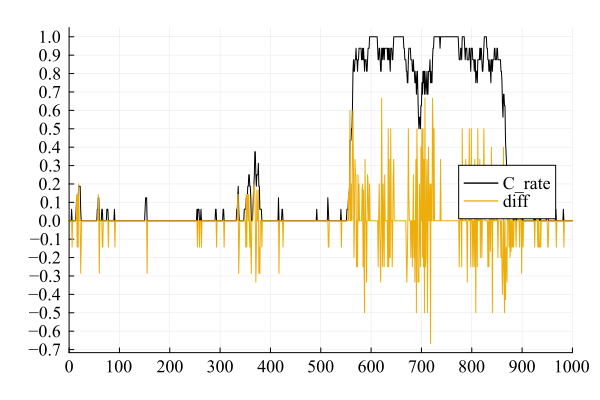

In [85]:
C_average_resource(m::Model)::Float64 = mean([(s == C ? r : 0) for (r, s) in zip(m.resource_vec, m.strategy_vec)])
D_average_resource(m::Model)::Float64 = mean([(s == D ? r : 0) for (r, s) in zip(m.resource_vec, m.strategy_vec)])
C_maximum_resource(m::Model)::Float64 = maximum([(s == C ? r : 0) for (r, s) in zip(m.resource_vec, m.strategy_vec)])
D_maximum_resource(m::Model)::Float64 = maximum([(s == D ? r : 0) for (r, s) in zip(m.resource_vec, m.strategy_vec)])

C_average_resource_vec = [C_average_resource(m) for m in after_death_birth_log]
D_average_resource_vec = [D_average_resource(m) for m in after_death_birth_log]
C_maximum_resource_vec = [C_maximum_resource(m) for m in after_death_birth_log]
D_maximum_resource_vec = [D_maximum_resource(m) for m in after_death_birth_log]

parent_C_rate_vec = [length(id_vec) > 0 ? mean(m.strategy_vec[id_vec] .== C) : 0 for (id_vec, m) in zip(parent_id_vec_vec, before_death_birth_log)]
children_C_rate_vec = [length(id_vec) > 0 ? mean(m.strategy_vec[id_vec] .== C) : 0 for (id_vec, m) in zip(death_id_vec_vec, before_death_birth_log)]
@show sum(parent_C_rate_vec .- children_C_rate_vec .> 0)
@show sum(parent_C_rate_vec .- children_C_rate_vec .== 0)
@show sum(parent_C_rate_vec .- children_C_rate_vec .< 0)

plot(xlim=(0, p.generations), xticks=0:100:p.generations, yticks=-1:0.1:1, lc=CS.BLACK, legend=:right)
plot!(C_rate_vec, label="C_rate", lc=CS.BLACK)
# plot!(moving_average(parent_C_rate_vec), label="parent_C_rate", lc=CS.RED)
# plot!(moving_average(children_C_rate_vec), label="children_C_rate", lc=CS.BLUE)
plot!(parent_C_rate_vec .- children_C_rate_vec, label="diff", lc=CS.ORANGE)

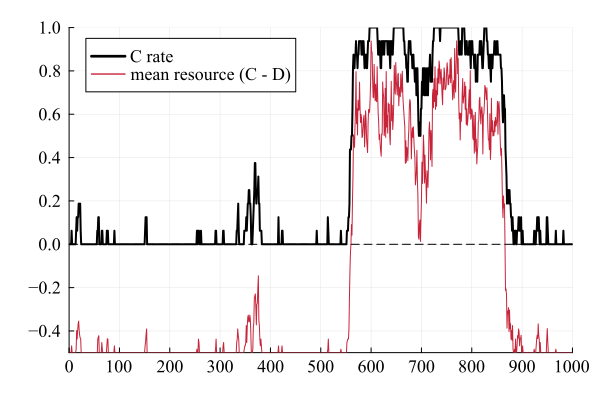

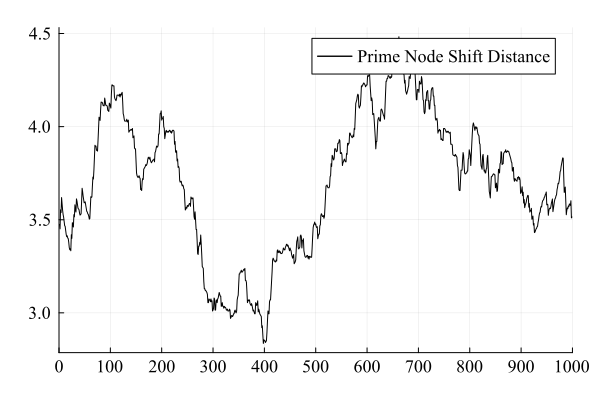

In [87]:
plt1 = plot(xlim=(0, p.generations), xticks=0:100:p.generations, ylim=(-0.5, 1.0), yticks=-0.4:0.2:1.0)
plot!(C_rate_vec, label="C rate", lc=CS.BLACK, lw=2)
# plot!(C_average_resource_vec)
# plot!(D_average_resource_vec)
# plot!(C_average_resource_vec, label="mean resource (C)", lc=CS.ORANGE)
plot!(C_average_resource_vec .- D_average_resource_vec, label="mean resource (C - D)", lc=CS.RED)
# plot!(C_maximum_resource_vec .- D_maximum_resource_vec, label="max resource (C - D)", lc=CS.BLUE)
# plot!(twinx(), C_mutation_rate_vec, label="C rate by mutation", lc=CS.BLACK, alpha=0.6, xlim=(0, p.generations), ylim=(-0.005, 0.01), yticks=-0.004:0.002:0.01)
plot!(fill(0, p.generations), lc=:black, ls=:dash, label=false)
display(plt1)

# tでCにアサインされるリソース、t+1でCにアサインされるリソース. (mean resource (C_{t+1} - C_t))

# 環境変動
prime_node_vec = [m.peak_node for m in after_death_birth_log]
prime_node_shift_vec = calc_prime_node_shift_vec(prime_node_vec)
plt2 = plot(xlim=(0, p.generations), xticks=0:100:p.generations)
plot!(moving_average(prime_node_shift_vec, 100), lc=CS.BLACK, label="Prime Node Shift Distance")
display(plt2)

In [10]:
# prime_node_shift_vec = calc_prime_node_shift_vec(peak_node_vec)

# function detail_transition(range::UnitRange; legend_x::Float64)::Nothing
#     min_range = minimum(range)
#     max_range = maximum(range)

#     xticks = (min_range - 1):10:max_range
#     h_xticks = (0:10:(max_range - min_range + 1), xticks)

#     title = "Cooperation Rate Transition (from $(min_range) to $(max_range))"
#     plt = plot(xticks=xticks, xlabel="Generation", title=title)
#     plot!(range, C_rate_vec[range], 
#         label="Cooperation rate", linewidth=2, color=:black, legend=(legend_x, 0.9), fg_legend=:transparent,
#         ylabel="Cooperation rate", ylim=(0.17, 0.82), yticks=0.2:0.1:0.8)
#     plot!(twinx(), range, moving_average(prime_node_shift_vec[range], 10),
#         label="Prime node shift", linewidth=1, color=:black, linestyle=:dash, legend=(legend_x, 0.8), fg_legend=:transparent,
#         ylabel="Prime Node Shift Mean Distance")
#     display(plt)
#     savefig("img/fig3_cd_$(min_range)_$(max_range).png")
    
#     return
# end

# # detail
# detail_transition(3671:3770, legend_x = 0.15)
# detail_transition(8601:8700, legend_x = 0.75);